In [133]:
import math
import re

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rtree
import numpy as np
from tqdm import tqdm
from shapely import Point



    * Parcels in a very high fire severity zone.
    * Parcels at risk of a one-foot rise in sea level.
    * Parcels with a designated historic resource.
    * Parcels is designated in a low-resource area.
    * Parcels in a station area where the local zoning already allows 50% of the units and floor area that would have been allowed by SB 79.

### DATA COLLECTION

In [253]:
## import overlays
low_resource_zones = gpd.read_file('data/low_resource_la.gpkg')
historic_zones = gpd.read_file("data/Historic_Preservation_Overlay_Zones.geojson")
fire_zones = gpd.read_file("data/California_High_Fire_Zones.gpkg")


In [254]:
parcels = gpd.read_file('final_parcels_merged.geojson')


In [255]:
# Load the station shapefile
stations = gpd.read_file("data/Enterances_79.geojson")
stations = stations[["79_Tier", "geometry"]]

# Ensure the GeoDataFrame has a projected CRS in feet/meters for buffering (1 mile ≈ 1609.34 meters)
if stations.crs is None or stations.crs.is_geographic:
    # Reproject to a projected CRS suitable for LA (e.g., EPSG:6420 or 2229)
    stations = stations.to_crs(
        epsg=6420
    )  # NAD83 / California zone 5 (ftUS) or 2229 depending on your data

tier_1 = stations[stations["79_Tier"] == 1]
tier_2 = stations[stations["79_Tier"] == 2]

/var/folders/20/rngmq8j10bx10n2wpq0ndk2w0000gn/T/ipykernel_55348/1169638617.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  catchment_union_1_h = catchment_buffers_1.unary_union
/var/folders/20/rngmq8j10bx10n2wpq0ndk2w0000gn/T/ipykernel_55348/1169638617.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  catchment_union_2_h = catchment_buffers_2.unary_union
/var/folders/20/rngmq8j10bx10n2wpq0ndk2w0000gn/T/ipykernel_55348/1169638617.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  catchment_union_1_q = catchment_buffers_1_q.unary_union
/var/folders/20/rngmq8j10bx10n2wpq0ndk2w0000gn/T/ipykernel_55348/1169638617.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  catchment_union_2_q = catchment_buffers_2_q.unary_union
/var/folders/20/rngmq8j10bx10n2wpq0n

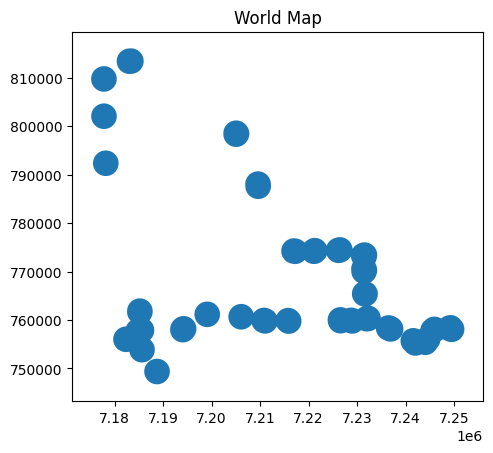

In [256]:
# Create 1-mile buffers around each station (1 mile ≈ 5280 feet)
catchment_buffers_1 = tier_1.copy()
catchment_buffers_1["geometry"] = tier_1.buffer(2640)  # 1/2 mile buffer in feet

catchment_buffers_2 = tier_2.copy()
catchment_buffers_2["geometry"] = tier_2.buffer(2640)  # 1/2 mile buffer in feet

catchment_buffers_1_q = tier_1.copy()
catchment_buffers_1_q["geometry"] = tier_1.buffer(1320)  # 1/4 mile buffer in feet

catchment_buffers_2_q = tier_2.copy()
catchment_buffers_2_q["geometry"] = tier_2.buffer(1320)  # 1/4 mile buffer in feet

catchment_buffers_1_e = tier_1.copy()
catchment_buffers_1_e["geometry"] = tier_1.buffer(125) 

catchment_buffers_2_e = tier_2.copy()
catchment_buffers_2_e["geometry"] = tier_2.buffer(125)

# Optional: merge all buffers into a single multipolygon for filtering
catchment_union_1_h = catchment_buffers_1.unary_union
catchment_union_2_h = catchment_buffers_2.unary_union
catchment_union_1_q = catchment_buffers_1_q.unary_union
catchment_union_2_q = catchment_buffers_2_q.unary_union
catchment_union_1_e = catchment_buffers_1_e.unary_union
catchment_union_2_e = catchment_buffers_2_e.unary_union


catchment_gdf_1_h = gpd.GeoDataFrame(
    geometry=[catchment_union_1_h], crs=catchment_buffers_1.crs
)

catchment_gdf_1_h.plot()
plt.title("World Map")
plt.show()

other_gdf = parcels.to_crs(catchment_gdf_1_h.crs)
assert other_gdf.crs == catchment_gdf_1_h.crs

In [257]:
union_1_ent = catchment_union_1_e
union_1_qtr = catchment_union_1_q
union_1_half = catchment_union_1_h

union_2_ent = catchment_union_2_e
union_2_qtr = catchment_union_2_q
union_2_half = catchment_union_2_h




def determine_upzoned_zone(geom):
    if geom.intersects(union_1_ent):
        return "R7"
    elif geom.intersects(union_2_ent):
        return "R6"
    elif geom.intersects(union_1_qtr):
        return "R5"
    elif geom.intersects(union_1_half):
        return "R4"
    elif geom.intersects(union_2_qtr):
        return "R4"
    elif geom.intersects(union_2_half):
        return "R3"
    else:
        return None


# other_gdf["upzoned"] = other_gdf.geometry.apply(determine_upzoned_zone)

tqdm.pandas()  # This monkey-patches pandas to support progress_apply

# Use progress_apply instead of apply
other_gdf["upzoned"] = other_gdf.geometry.progress_apply(determine_upzoned_zone)

other_gdf.head()

100%|██████████| 641487/641487 [18:20<00:00, 583.15it/s]  


,AIN,Property Location,zone_type,acreage,Number of Units,Property_Tax_Value,zone_cmplt,Land Value,Improvement Value,Improvement Base Year,...,Location Longitude,Taxable Value,Property taxable?,Effective Year,zip_code,tax_per_acre_parcel,tax_per_acre_zone,tax_per_acre_zone_recent,geometry,upzoned
0,2004001003,8321 FAUST AVE LOS ANGELES CA 91304,R,0.222,1,10128.65,RE9-1,711689,301176,2006,...,-118.620681,1012865,Y,1973.0,91304,45624.549550,35713.96,87614.06,"MULTIPOLYGON (((7130871.97 815556.619, 7130722...",None
1,2004001004,8313 FAUST AVE LOS ANGELES CA 91304,R,0.227,1,6264.17,RE9-1,370538,255879,2010,...,-118.620681,626417,Y,1973.0,91304,27595.462555,35713.96,87614.06,"MULTIPOLYGON (((7130873.459 815490.003, 713072...",None
2,2004001005,8309 FAUST AVE LOS ANGELES CA 91304,R,0.221,1,7249.37,RE9-1,526360,198577,2018,...,-118.620688,724937,Y,1973.0,91304,32802.579186,35713.96,87614.06,"MULTIPOLYGON (((7130873.959 815466.395, 713087...",None
3,2004001008,8325 MAYNARD AVE LOS ANGELES CA 91304,R,0.271,1,3433.86,RE11-1,128421,221965,1980,...,-118.622718,343386,Y,1978.0,91304,12671.070111,35713.96,87614.06,"MULTIPOLYGON (((7130230.366 815654.769, 713023...",None
4,2004001009,8311 MAYNARD AVE LOS ANGELES CA 91304,R,0.342,1,3429.45,RE11-1,139933,210012,1984,...,-118.623062,342945,Y,1978.0,91304,10027.631579,35713.96,87614.06,"MULTIPOLYGON (((7130161.986 815536.911, 713015...",None


In [258]:
other_gdf["upzoned"].value_counts()

upzoned
R3    77696
R4    50677
R5     5881
R6      399
R7      147
Name: count, dtype: int64

In [259]:
upzoned_parcels = other_gdf[other_gdf["upzoned"].notna()].copy()

In [261]:
upzoned_parcels["upzoned"].value_counts()

upzoned
R3    77696
R4    50677
R5     5881
R6      399
R7      147
Name: count, dtype: int64

In [262]:
low_resource_zones.head()

,fips,fips_bg,county_name,region,pct_above_200_pov,pct_bachelors_plus,pct_employed,home_value,math_prof,read_prof,...,pct_asian,pct_black,pct_hispanic,pct_poc,pct_asian_cty,pct_black_cty,pct_hispanic_cty,pct_poc_cty,pov_seg_flag,geometry
0,06037101220,None,Los Angeles,Los Angeles Region,0.720770,0.289453,0.702606,645300.0,0.360625,0.352215,...,0.124390,NaN,0.420282,0.573398,0.14619,0.075795,0.486842,0.747886,0.0,"MULTIPOLYGON (((-118.28592 34.25227, -118.2859..."
1,06037101222,None,Los Angeles,Los Angeles Region,0.586538,NaN,0.650802,NaN,0.360625,0.352215,...,NaN,NaN,0.461182,0.545228,0.14619,0.075795,0.486842,0.747886,NaN,"MULTIPOLYGON (((-118.29318 34.25233, -118.2886..."
2,06037102103,None,Los Angeles,Los Angeles Region,0.641767,0.290447,0.654630,832200.0,0.299945,0.403020,...,NaN,NaN,NaN,0.204471,0.14619,0.075795,0.486842,0.747886,0.0,"MULTIPOLYGON (((-118.36533 34.2287, -118.35546..."
3,06037104103,None,Los Angeles,Los Angeles Region,0.788466,0.168473,0.662800,630400.0,0.295008,0.342741,...,0.053726,NaN,0.717122,0.932726,0.14619,0.075795,0.486842,0.747886,0.0,"MULTIPOLYGON (((-118.40085 34.28159, -118.3952..."
4,06037104105,None,Los Angeles,Los Angeles Region,0.551913,0.188361,0.632949,459300.0,0.305407,0.348620,...,0.048103,NaN,0.859887,0.943019,0.14619,0.075795,0.486842,0.747886,0.0,"MULTIPOLYGON (((-118.41169 34.27369, -118.4084..."


In [263]:
historic_zones.head()

,OBJECTID,NAME,GlobalID,Shape__Area,Shape__Length,geometry
0,1,Balboa Highlands,ca9934e3-1d0b-4a82-9f26-6fadf10e90ef,1.642466e+06,7878.515344,"POLYGON ((-118.50374 34.29894, -118.50376 34.2..."
1,2,Van Nuys,c6103806-a403-4247-952d-13635a8bdeb8,2.658830e+06,12146.880621,"MULTIPOLYGON (((-118.44496 34.19142, -118.4449..."
2,3,Lincoln Heights,f7ef3d1b-ad36-4edc-b351-c03f12ab3bf2,9.422781e+06,26972.189766,"MULTIPOLYGON (((-118.21701 34.07976, -118.2167..."
3,4,Miracle Mile North,b36aea01-6b91-427b-917c-fa679f20e150,5.588171e+06,10497.897783,"POLYGON ((-118.3537 34.07169, -118.35331 34.07..."
4,5,Harvard Heights,b99c778d-f019-4204-b398-73639f2f81f5,9.021733e+06,12487.650240,"POLYGON ((-118.30029 34.04632, -118.30029 34.0..."


In [264]:
fire_zones.head()

,OBJECTID,HFTD,Shape_Leng,Shape__Area,Shape__Length,geometry
0,2,Tier 3,8.525357e+06,3.232697e+10,8.525357e+06,"MULTIPOLYGON (((-83627.531 -271559.795, -83356..."
1,1,Tier 2,3.405218e+07,1.499847e+11,3.405218e+07,"MULTIPOLYGON (((-306444.647 447962.033, -30346..."


In [265]:
upzoned_parcels.head()

,AIN,Property Location,zone_type,acreage,Number of Units,Property_Tax_Value,zone_cmplt,Land Value,Improvement Value,Improvement Base Year,...,Location Longitude,Taxable Value,Property taxable?,Effective Year,zip_code,tax_per_acre_parcel,tax_per_acre_zone,tax_per_acre_zone_recent,geometry,upzoned
1443,2010004015,22010 NORDHOFF ST LOS ANGELES CA 91311,R,0.604,1,6536.89,RE11-1,390430,263259,2018,...,-118.606420,653689,Y,1962.0,91311,10822.665563,35713.96,87614.06,"MULTIPOLYGON (((7134967.86 821179.065, 7135044...",R3
1444,2010004016,22000 NORDHOFF ST LOS ANGELES CA 91311,R,0.602,1,3613.35,RE11-1,243560,124775,1988,...,-118.606152,361335,Y,1962.0,91311,6002.242525,35713.96,87614.06,"MULTIPOLYGON (((7135111.402 821175.531, 713512...",R3
1447,2010004019,8969 HANNA AVE LOS ANGELES CA 91304,R,0.265,1,2881.55,RE11-1,130076,158079,1995,...,-118.606520,288155,Y,1967.0,91304,10873.773585,35713.96,87614.06,"MULTIPOLYGON (((7135060.494 820622.083, 713505...",R3
1448,2010004020,8971 HANNA AVE LOS ANGELES CA 91304,R,0.495,1,1514.21,RE11-1,42474,115947,1977,...,-118.606477,151421,Y,1967.0,91304,3059.010101,35713.96,87614.06,"MULTIPOLYGON (((7134967.202 820876.415, 713505...",R3
1449,2010004021,8973 HANNA AVE LOS ANGELES CA 91304,R,0.361,1,10731.21,RE11-1,468889,604232,2009,...,-118.606152,1073121,Y,2008.0,91304,29726.343490,35713.96,87614.06,"MULTIPOLYGON (((7135118.909 820834.091, 713512...",R3


In [307]:
# commercial properties get punted
upzoned_parcels.loc[upzoned_parcels['zone_type'] == 'C', 'delay'] = "delayed"

# multi-family residential properties get punted
upzoned_parcels.loc[
    upzoned_parcels['assigned_zoning_bucket'].isin(['R3', 'R4', 'R5']),
    'delay'
] = "delayed"

# some multi-family gets added back
upzoned_parcels.loc[
    upzoned_parcels['upzoned'].isin(['R5', 'R6', 'R7']) &
    (upzoned_parcels['assigned_zoning_bucket'] == 'R3'),
    'delay'
] = None

In [308]:
# Reproject all zone datasets to match upzoned_parcels's CRS
target_crs = upzoned_parcels.crs  # EPSG:6420
low_resource_zones = low_resource_zones.to_crs(target_crs)
historic_zones = historic_zones.to_crs(target_crs)
fire_zones = fire_zones.to_crs(target_crs)

# Combine all delay zones into one
all_delay_zones = pd.concat([low_resource_zones, fire_zones], 
                            ignore_index=True).to_crs(target_crs)

# Single spatial join
intersecting = gpd.sjoin(upzoned_parcels, all_delay_zones, 
                        how='inner', predicate='intersects')

# Mark all intersecting parcels as delayed
upzoned_parcels.loc[intersecting.index, "delay"] = "delayed"

print(f"Found {len(intersecting.index.unique())} delayed parcels")

Found 84950 delayed parcels


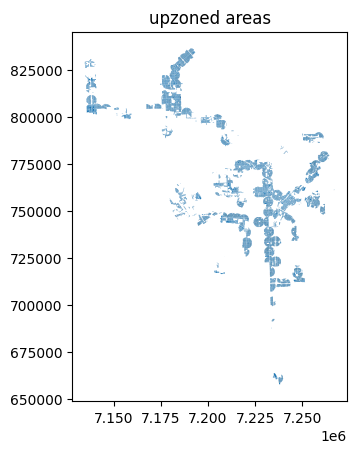

In [309]:
upzoned_parcels[upzoned_parcels['delay'] == "delayed"].plot()
plt.title("upzoned areas")
plt.show()

Allowed units = (buildable area X floor area ratio) / 800 sf * 85%

In [310]:
far_lookup = {"R7": 4.5, "R6": 4, "R5": 3.5, "R4": 3, "R3": 2.5}
density_lookup = {"R7": 160, "R6": 140, "R5": 120, "R4": 100, "R3": 80}

upzoned_parcels['FAR'] = upzoned_parcels['upzoned'].map(far_lookup)
upzoned_parcels['density'] = upzoned_parcels['upzoned'].map(density_lookup)

# Calculate FAR limited units
far_limited = np.floor((
    (upzoned_parcels['acreage'] * 43560 * upzoned_parcels['FAR']) / 800
) * 0.85)

# Calculate Density limited units
density_limited = np.floor(upzoned_parcels['acreage'] * upzoned_parcels['density'])

# Take the minimum of the two
upzoned_parcels['potential_units'] = np.minimum(far_limited, density_limited)


In [311]:
# Remove parcels unlikely to be developed because of existing density
upzoned_parcels['viable'] = True

upzoned_parcels.loc[
    upzoned_parcels['assigned_zoning_bucket'].isin(['R3', 'R4', 'R5']) &
    (upzoned_parcels['Land Value']/upzoned_parcels['Improvement Value'] < 1),
    'viable'
] = False

# Remove parcels with more than 2 existing units
upzoned_parcels.loc[upzoned_parcels['Number of Units'] > 2, 'viable'] = False

# Remove extra parcels owned by public
upzoned_parcels.loc[upzoned_parcels["Land Value"] == 0, 'viable'] = False


# make sure removed parcels are not counted toward units
upzoned_parcels.loc[upzoned_parcels["viable"] == False, 'potential_units'] = 0

In [312]:
# claculate net units
upzoned_parcels['net_units'] = upzoned_parcels['potential_units'] - upzoned_parcels['Number of Units']

# make sure to 0 out units
upzoned_parcels.loc[upzoned_parcels["net_units"] < 0, 'net_units'] = 0

In [313]:
upzoned_parcels.head()

,AIN,Property Location,zone_type,acreage,Number of Units,Property_Tax_Value,zone_cmplt,Land Value,Improvement Value,Improvement Base Year,...,tax_per_acre_zone,tax_per_acre_zone_recent,geometry,upzoned,delay,FAR,potential_units,density,viable,net_units
1443,2010004015,22010 NORDHOFF ST LOS ANGELES CA 91311,R,0.604,1,6536.89,RE11-1,390430,263259,2018,...,35713.96,87614.06,"MULTIPOLYGON (((7134967.86 821179.065, 7135044...",R3,None,2.5,48.0,80,True,47.0
1444,2010004016,22000 NORDHOFF ST LOS ANGELES CA 91311,R,0.602,1,3613.35,RE11-1,243560,124775,1988,...,35713.96,87614.06,"MULTIPOLYGON (((7135111.402 821175.531, 713512...",R3,None,2.5,48.0,80,True,47.0
1447,2010004019,8969 HANNA AVE LOS ANGELES CA 91304,R,0.265,1,2881.55,RE11-1,130076,158079,1995,...,35713.96,87614.06,"MULTIPOLYGON (((7135060.494 820622.083, 713505...",R3,None,2.5,21.0,80,True,20.0
1448,2010004020,8971 HANNA AVE LOS ANGELES CA 91304,R,0.495,1,1514.21,RE11-1,42474,115947,1977,...,35713.96,87614.06,"MULTIPOLYGON (((7134967.202 820876.415, 713505...",R3,None,2.5,39.0,80,True,38.0
1449,2010004021,8973 HANNA AVE LOS ANGELES CA 91304,R,0.361,1,10731.21,RE11-1,468889,604232,2009,...,35713.96,87614.06,"MULTIPOLYGON (((7135118.909 820834.091, 713512...",R3,None,2.5,28.0,80,True,27.0


In [314]:
upzoned_parcels.to_file("/output/sb79_parcels.gpkg", driver="GPKG")

In [320]:
total_units = upzoned_parcels['net_units'][upzoned_parcels['viable'] == True].sum()


upzoned_parcels[upzoned_parcels['delay'] != "delayed"]

delayed_units = upzoned_parcels['net_units'][(upzoned_parcels['delay'] != "delayed") & (upzoned_parcels['viable'] == True)].sum()

print("new units total", total_units)
print("new units 2026", delayed_units)
print("new units 2030", total_units-delayed_units)

new units total 1393217.0
new units 2026 396132.0
new units 2030 997085.0


## Property Tax per Parcel Analaysis

In [316]:



new_parcels = upzoned_parcels[upzoned_parcels["Improvement Base Year"] > 2010]

new_parcels.head()

,AIN,Property Location,zone_type,acreage,Number of Units,Property_Tax_Value,zone_cmplt,Land Value,Improvement Value,Improvement Base Year,...,tax_per_acre_zone,tax_per_acre_zone_recent,geometry,upzoned,delay,FAR,potential_units,density,viable,net_units
1443,2010004015,22010 NORDHOFF ST LOS ANGELES CA 91311,R,0.604,1,6536.89,RE11-1,390430,263259,2018,...,35713.96,87614.06,"MULTIPOLYGON (((7134967.86 821179.065, 7135044...",R3,None,2.5,48.0,80,True,47.0
1454,2010004026,8982 MEGAN AVE LOS ANGELES CA 91304,R,0.484,1,9510.00,RE11-1,705100,245900,2024,...,35713.96,87614.06,"MULTIPOLYGON (((7135491.137 820731.669, 713540...",R3,None,2.5,38.0,80,True,37.0
1456,2010004028,8976 MEGAN AVE LOS ANGELES CA 91304,R,0.521,1,7122.84,RE11-1,362419,349865,2013,...,35713.96,87614.06,"MULTIPOLYGON (((7135669.172 820491.761, 713559...",R3,None,2.5,41.0,80,True,40.0
1457,2010004029,8972 MEGAN AVE LOS ANGELES CA 91304,R,0.321,1,11805.41,RE11-1,767295,413246,2022,...,35713.96,87614.06,"MULTIPOLYGON (((7135682.737 820402.303, 713559...",R3,None,2.5,25.0,80,True,24.0
1458,2010004030,8964 MEGAN AVE LOS ANGELES CA 91304,R,0.278,1,14680.00,RE11-1,960000,515000,2024,...,35713.96,87614.06,"MULTIPOLYGON (((7135694.907 820322.037, 713559...",R3,None,2.5,22.0,80,True,21.0
